# 0. Overview pipeline

In [ ]:
# ┌─────────────────────────────────────┐
# │  CT Volume (512, 512, Z)             │
# └──────────────┬──────────────────────┘
#                │
#                │ Loop over each slice
#                ▼
# ┌─────────────────────────────────────┐
# │  Slice 2D → Resize → Predict         │
# │  Repeat Z times                      │
# └──────────────┬──────────────────────┘
#                │
#                │ Stack predictions
#                ▼
# ┌─────────────────────────────────────┐
# │  Prediction Volume (512, 512, Z)     │ ← 3D VOLUME
# └──────────────┬──────────────────────┘
#                │
#                │ POST-PROCESSING 3D:
#                │ 1. Remove small objects
#                │ 2. Keep largest component
#                │ 3. Fill holes
#                ▼
# ┌─────────────────────────────────────┐
# │  Cleaned Volume (512, 512, Z)        │
# └──────────────┬──────────────────────┘
#                │
#                │ Loop over each slice
#                ▼
# ┌─────────────────────────────────────┐
# │  RLE encode each slice               │
# │  → submission.csv                    │
# └─────────────────────────────────────┘

# 1. Import Libraries & Configre parameters

## 1.1. Import libraries

In [1]:
!pip install -q segmentation_models_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.2 MB/s eta 0:00:00:00:0100:01
ERROR: pip's depend

In [18]:
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F

import numpy as np
import pandas as pd
import nibabel as nib
import cv2
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from skimage.morphology import remove_small_objects
from skimage.measure import label
from scipy.ndimage import binary_fill_holes
from tqdm.auto import tqdm
import wandb

import glob, os, gc
from datetime import datetime
from time import time
import warnings
import psutil
warnings.filterwarnings("ignore")

print("✅ Import libraries completed!")
print(f"✅ PyTorch version: {torch.__version__}")
print(f"✅ CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"✅ GPU: {torch.cuda.get_device_name(0)}")

✅ Import libraries completed!
✅ PyTorch version: 2.6.0+cu124
✅ CUDA available: True
✅ GPU: Tesla T4


## 1.2. Config params

In [3]:
HU_MIN, HU_MAX = -100, 250  # Hounsfield Units window for liver
IMAGE_SIZE = 512  # Resize slices to 512x512
N_SLICES = 3  # 2.5D: use 3 consecutive slices as channels

### Data paths
IMAGE_DIR = "/kaggle/input/aio2025liverseg/train/volume"
LABEL_DIR = "/kaggle/input/aio2025liverseg/train/segmentation"
TEST_DIR = "/kaggle/input/aio2025liverseg/test"

### Data split
TRAIN_SIZE = 0.875  # 87.5% train, 12.5% val
RANDOM_STATE = 42

### Training hyperparameters
BATCH_SIZE = 10  
NUM_WORKERS = 4
EPOCHS = 100
LR = 1e-4
WEIGHT_DECAY = 1e-4

### Early stopping
PATIENCE = 15

### Model architecture
ARCHITECTURE = 'UnetPlusPlus'
ENCODER = 'efficientnet-b5'
ENCODER_WEIGHTS = 'imagenet'

### Wandb config
WANDB_ENTITY = "levanluucmg-aio"
WANDB_PROJECT = "liver_tumor_segmentation_in_3D_images_kaggle"
EXTRA_NOTE = "2.5D_UNet++_EfficientNetB5"

print("\n" + "="*70)
print("HYPERPARAMETERS")
print("="*70)
print(f"Image size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"2.5D approach: {N_SLICES} consecutive slices")
print(f"HU window: [{HU_MIN}, {HU_MAX}]")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LR}")
print(f"Max epochs: {EPOCHS}")
print(f"Model: {ARCHITECTURE}")
print(f"Encoder: {ENCODER}")
print("="*70)


HYPERPARAMETERS
Image size: 512x512
2.5D approach: 3 consecutive slices
HU window: [-100, 250]
Batch size: 10
Learning rate: 0.0001
Max epochs: 100
Model: UnetPlusPlus
Encoder: efficientnet-b5


# 2. Data Processing

## 2.1. Preprocessing (offline - run 1 time only)

In [4]:
# def pre_extract_slices_to_disk(volume_list, output_dir, n_slices=3, min_liver_pixels=100):
#     """
#     Pre-extract all valid slices and save to disk
#     Run this ONCE before training
    
#     Args:
#         volume_list: List of volume dicts
#         output_dir: Directory to save extracted slices
#         n_slices: Number of slices for 2.5D
#         min_liver_pixels: Minimum liver pixels
#     """
#     os.makedirs(output_dir, exist_ok=True)
#     os.makedirs(os.path.join(output_dir, "images"), exist_ok=True)
#     os.makedirs(os.path.join(output_dir, "masks"), exist_ok=True)
    
#     half_slices = n_slices // 2
#     slice_metadata = []
    
#     print(f"{'='*70}")
#     print(f"PRE-EXTRACTING SLICES TO DISK: {output_dir}")
#     print(f"{'='*70}")
    
#     for vol_idx, vol_dict in enumerate(tqdm(volume_list, desc="Extracting")):
#         # Load volume
#         img_nii = nib.load(vol_dict['image'])
#         img_data = img_nii.get_fdata().astype(np.float32)
        
#         label_nii = nib.load(vol_dict['label'])
#         label_data = label_nii.get_fdata().astype(np.uint8)
        
#         # Preprocess
#         img_data = np.clip(img_data, HU_MIN, HU_MAX)
#         img_data = (img_data - HU_MIN) / (HU_MAX - HU_MIN)
#         label_data = (label_data > 0).astype(np.uint8)
        
#         # Extract slices
#         n_slices_total = img_data.shape[2]
        
#         for z_idx in range(n_slices_total):
#             # Filter
#             mask_slice = label_data[:, :, z_idx]
#             if (mask_slice > 0).sum() < min_liver_pixels:
#                 continue
            
#             # Extract 2.5D
#             slices_list = []
#             for offset in range(-half_slices, half_slices + 1):
#                 z = z_idx + offset
#                 z = max(0, min(z, n_slices_total - 1))
#                 slices_list.append(img_data[:, :, z])
            
#             image_25d = np.stack(slices_list, axis=-1)  # (H, W, 3)
#             mask_2d = mask_slice
            
#             # Resize
#             image_25d = cv2.resize(image_25d, (IMAGE_SIZE, IMAGE_SIZE), 
#                                   interpolation=cv2.INTER_LINEAR)
#             mask_2d = cv2.resize(mask_2d, (IMAGE_SIZE, IMAGE_SIZE), 
#                                 interpolation=cv2.INTER_NEAREST)
            
#             # Save as NPZ (compressed)
#             slice_id = f"vol{vol_idx:03d}_slice{z_idx:03d}"
            
#             img_path = os.path.join(output_dir, "images", f"{slice_id}.npz")
#             mask_path = os.path.join(output_dir, "masks", f"{slice_id}.npz")
            
#             np.savez_compressed(img_path, data=image_25d)
#             np.savez_compressed(mask_path, data=mask_2d)
            
#             slice_metadata.append({
#                 'image_path': img_path,
#                 'mask_path': mask_path,
#                 'slice_id': slice_id
#             })
        
#         del img_data, label_data
#         gc.collect()
    
#     # Save metadata
#     metadata_df = pd.DataFrame(slice_metadata)
#     metadata_df.to_csv(os.path.join(output_dir, "metadata.csv"), index=False)
    
#     print(f"✅ Extracted {len(slice_metadata)} slices")
#     print(f"✅ Saved to: {output_dir}")
    
#     return metadata_df


# class PreExtractedDataset(Dataset):
#     """
#     Dataset for pre-extracted slices
#     Super fast loading!
#     """
#     def __init__(self, metadata_csv, transform=None):
#         self.metadata = pd.read_csv(metadata_csv)
#         self.transform = transform
        
#     def __len__(self):
#         return len(self.metadata)
    
#     def __getitem__(self, idx):
#         row = self.metadata.iloc[idx]
        
#         # Load from disk (very fast with npz)
#         image = np.load(row['image_path'])['data'].astype(np.float32)
#         mask = np.load(row['mask_path'])['data'].astype(np.float32)
        
#         # Augmentation
#         if self.transform:
#             augmented = self.transform(image=image, mask=mask)
#             image = augmented['image']
#             mask = augmented['mask']
        
#         mask = mask.unsqueeze(0)
        
#         return image, mask


# image_file_paths = sorted(glob.glob(f"{IMAGE_DIR}/*.nii"))
# label_file_paths = sorted(glob.glob(f"{LABEL_DIR}/*.nii"))

# # Create volume list
# volume_files = [
#     {"image": img_path, "label": lbl_path}
#     for img_path, lbl_path in zip(image_file_paths, label_file_paths)
# ]

# print(f"\n{'='*70}")
# print("DATA LOADING")
# print(f"{'='*70}")
# print(f"✅ Found {len(volume_files)} 3D CT volumes")

# ### Train/Val split (IMPORTANT: split by volumes, not slices!)
# train_volumes, val_volumes = train_test_split(
#     volume_files,
#     train_size=TRAIN_SIZE,
#     random_state=RANDOM_STATE,
#     shuffle=True
# )

# print(f"📊 Train volumes: {len(train_volumes)}")
# print(f"📊 Val volumes: {len(val_volumes)}")

# # Run pre-extraction ONCE
# print("\n🔧 Running pre-extraction...")
# train_metadata = pre_extract_slices_to_disk(
#     volume_list=train_volumes,
#     output_dir="./preprocessed_data/train",
#     n_slices=N_SLICES,
#     min_liver_pixels=0 # Keep all slices for training
# )

# val_metadata = pre_extract_slices_to_disk(
#     volume_list=val_volumes,
#     output_dir="./preprocessed_data/val",
#     n_slices=N_SLICES,
#     min_liver_pixels=0  # Keep all slices for validation
# )

In [5]:
# import shutil, os

# shutil.make_archive("preprocessed_data", "zip", "/kaggle/working", "/kaggle/working/preprocessed_data")

## 2.2. Dataset & DataLoader

In [12]:
class PreExtractedDataset(Dataset):
    """
    Dataset for pre-extracted slices
    Super fast loading!
    """
    def __init__(self, metadata_csv, transform=None):
        self.metadata = pd.read_csv(metadata_csv)
        self.transform = transform
        self.base_dir = os.path.dirname(metadata_csv)
        
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        
        # Extract relative filenames (basename)
        img_name = os.path.basename(row['image_path'])
        mask_name = os.path.basename(row['mask_path'])

        # Construct correct paths on Kaggle
        image_path = os.path.join(self.base_dir, "images", img_name)
        mask_path = os.path.join(self.base_dir, "masks", mask_name)

        # Load
        image = np.load(image_path)['data'].astype(np.float32)
        mask = np.load(mask_path)['data'].astype(np.float32)

        # Transform
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        mask = mask.unsqueeze(0)
        return image, mask

def get_train_transforms():
    """Training augmentation pipeline"""
    return A.Compose([
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, border_mode=cv2.BORDER_CONSTANT, p=0.5),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
        ToTensorV2()
    ])

def get_val_transforms():
    """Validation transform (no augmentation)"""
    return A.Compose([ToTensorV2()])

print("✅ Dataset and transforms defined!")

✅ Dataset and transforms defined!


In [13]:
image_file_paths = sorted(glob.glob(f"{IMAGE_DIR}/*.nii"))
label_file_paths = sorted(glob.glob(f"{LABEL_DIR}/*.nii"))

# Create volume list
volume_files = [
    {"image": img_path, "label": lbl_path}
    for img_path, lbl_path in zip(image_file_paths, label_file_paths)
]

print(f"\n{'='*70}")
print("DATA LOADING")
print(f"{'='*70}")
print(f"✅ Found {len(volume_files)} 3D CT volumes")

### Train/Val split (IMPORTANT: split by volumes, not slices!)
train_volumes, val_volumes = train_test_split(
    volume_files,
    train_size=TRAIN_SIZE,
    random_state=RANDOM_STATE,
    shuffle=True
)

print(f"📊 Train volumes: {len(train_volumes)}")
print(f"📊 Val volumes: {len(val_volumes)}")


DATA LOADING
✅ Found 80 3D CT volumes
📊 Train volumes: 70
📊 Val volumes: 10


In [14]:
### Create datasets
train_dataset = PreExtractedDataset(
    metadata_csv="/kaggle/input/train-preprocess-dataset/train/metadata.csv",
    transform=get_train_transforms()
)
val_dataset = PreExtractedDataset(
    metadata_csv="/kaggle/input/preprocess-2d-data/preprocessed_data/val/metadata.csv",
    transform=get_val_transforms()
)
print("✅ Pre-extracted datasets ready!")

### Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # Already sorted by volume!
    num_workers=NUM_WORKERS, 
    pin_memory=False,  # Set to False to save memory
    drop_last=True,
    persistent_workers=False 
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=False,
    persistent_workers=False
)

print(f"\n{'='*70}")
print("DATALOADER INFO")
print(f"{'='*70}")
print(f"✅ Train batches per epoch: {len(train_loader)} | Val batches: {len(val_loader)}")
print(f"✅ Train slices: {len(train_dataset)} | Val slices: {len(val_dataset)}")
print(f"✅ Train value range: {len(train_dataset)} | Val slices: {len(val_dataset)}")
print(f"{'='*70}")

# Force garbage collection
gc.collect()

✅ Pre-extracted datasets ready!

DATALOADER INFO
✅ Train batches per epoch: 2966 | Val batches: 494
✅ Train slices: 29668 | Val slices: 4936


15

# 3. Init model, optimizer, loss function

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"\n{'='*70}")
print("MODEL SETUP")
print(f"{'='*70}")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")

### Define Model: UNet++ with EfficientNet-B5
model = smp.UnetPlusPlus(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS, # ENCODER_WEIGHTS, if using pretrained
    in_channels=N_SLICES,  # 2.5D: 3 slices
    classes=1,  # Binary segmentation (liver vs background)
    activation=None,  # I'll apply sigmoid in loss
    decoder_attention_type="scse"  # Spatial-Channel Squeeze & Excitation
)

# Multi-GPU
if torch.cuda.device_count() > 1:
    print(f"✅ Using {torch.cuda.device_count()} GPUs with DataParallel")
    model = nn.DataParallel(model)

model = model.to(device)

print(f"✅ Model: {ARCHITECTURE}")
print(f"✅ Encoder: {ENCODER} (pretrained on {ENCODER_WEIGHTS})")
print(f"✅ Decoder attention: SCSE")

class DiceBCELoss(nn.Module):
    def __init__(self, weight_dice=0.7, weight_bce=0.3, smooth=1e-6):
        super().__init__()
        self.weight_dice = weight_dice
        self.weight_bce = weight_bce

    def forward(self, inputs, targets):
        preds = torch.sigmoid(inputs)
        # Compute BCE loss
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets)
        
        # Compute Dice loss
        smooth = 1e-6
        intersection = (preds * targets).sum()
        union = preds.sum() + targets.sum()
        dice_loss = 1 - (2. * intersection + smooth) / (union + smooth)

        # Combined the loss
        combined_loss = self.weight_dice * dice_loss + self.weight_bce * bce_loss
        return combined_loss


loss_fn = DiceBCELoss(weight_dice=0.7, weight_bce=0.3)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-7, last_epoch=-1)

print(f"✅ Loss: Combined (Dice + BCE)")
print(f"✅ Optimizer: AdamW (lr={LR}, weight_decay={WEIGHT_DECAY})")
print(f"✅ Scheduler: CosineAnnealingLR")


MODEL SETUP
Device: cuda
GPU: Tesla T4
Number of GPUs: 2
✅ Using 2 GPUs with DataParallel
✅ Model: UnetPlusPlus
✅ Encoder: efficientnet-b5 (pretrained on imagenet)
✅ Decoder attention: SCSE
✅ Loss: Combined (Dice + BCE)
✅ Optimizer: AdamW (lr=0.0001, weight_decay=0.0001)
✅ Scheduler: CosineAnnealingLR


In [ ]:
# !pip install torchinfo
# from torchinfo import summary

# summary(model)

# 4. Training

## 4.1. Configure funtioncs

In [11]:
def dice_coefficient(pred, target, threshold=0.5, smooth=1e-6):
    """Calculate Dice coefficient for evaluation"""
    pred = (torch.sigmoid(pred) > threshold).float()
    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return dice.item()

def iou_score(pred, target, threshold=0.5, smooth=1e-6):
    """Calculate IoU/Jaccard score"""
    pred = (torch.sigmoid(pred) > threshold).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.item()

# ============================================================================
# MEMORY OPTIMIZATION UTILITIES
# ============================================================================
def clear_memory():
    """Aggressively clear memory"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

# Monitor memory during training
def monitor_memory_callback():
    """Callback to monitor memory"""
    process = psutil.Process()
    mem_gb = process.memory_info().rss / 1024**3
    
    if mem_gb > 28:  # Warning if > 28GB (out of 30GB)
        print(f"⚠️  HIGH MEMORY WARNING: {mem_gb:.2f} GB")
        clear_memory()
    return mem_gb

# ============================================================================
# Training & Validation step
# ============================================================================
def train_step_optimized(model, loader, loss_fn, optimizer, scaler, device, epoch, accumulation_steps=4):
    """Training with memory monitoring"""
    model.train()
    
    running_loss = 0.0
    running_dice = 0.0
    running_iou = 0.0
    num_batches = 0

    optimizer.zero_grad(set_to_none=True)
    
    pbar = tqdm(loader, desc=f"[Epoch {epoch+1}/{EPOCHS}] Training")
    
    for batch_idx, (images, masks) in enumerate(pbar):
        images = images.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)
        
        with autocast():
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            loss = loss / accumulation_steps
        
        scaler.scale(loss).backward()
        if (batch_idx+1) % accumulation_steps == 0 or (batch_idx+1) == len(loader):
            
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Update weights
            scaler.step(optimizer)
            scaler.update()

            optimizer.zero_grad()
        
        with torch.inference_mode():
            dice = dice_coefficient(outputs, masks)
            iou = iou_score(outputs, masks)
        
        current_loss = loss.detach().cpu().item() * accumulation_steps
        running_loss += current_loss
        running_dice += dice
        running_iou += iou
        num_batches += 1
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f"{running_loss/num_batches:.4f}",
            'dice': f"{running_dice/num_batches:.4f}",
            'iou': f"{running_iou/num_batches:.4f}"
        })
        
        # Clean up immediately
        del images, masks, outputs, loss
        
        # Monitor memory every 50 batches
        if batch_idx % 50 == 0:
            mem_gb = monitor_memory_callback()
            pbar.set_postfix({
                'loss': f"{running_loss/num_batches:.4f}",
                'dice': f"{running_dice/num_batches:.4f}",
                'iou': f"{running_iou/num_batches:.4f}",
                'mem': f"{mem_gb:.1f}GB"
            })
    
    avg_loss = running_loss / num_batches
    avg_dice = running_dice / num_batches
    avg_iou = running_iou / num_batches
    
    return avg_loss, avg_dice, avg_iou

def validation_step_optimized(model, loader, loss_fn, device):
    """Validation with memory management"""
    model.eval()
    
    running_loss = 0.0
    running_dice = 0.0
    running_iou = 0.0
    num_batches = 0
    
    with torch.inference_mode():
        pbar = tqdm(loader, desc="Validation")
        
        for batch_idx, (images, masks) in enumerate(pbar):
            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)
            
            with autocast():
                outputs = model(images)
                loss = loss_fn(outputs, masks)
            
            dice = dice_coefficient(outputs, masks)
            iou = iou_score(outputs, masks)
            
            running_loss += loss.detach().cpu().item()
            running_dice += dice
            running_iou += iou
            num_batches += 1
            
            pbar.set_postfix({
                'loss': f"{running_loss/num_batches:.4f}",
                'dice': f"{running_dice/num_batches:.4f}",
                'iou': f"{running_iou/num_batches:.4f}"
            })
            
            # Clean up
            del images, masks, outputs, loss
            
            # Aggressive memory clearing every 20 batches
            if batch_idx % 20 == 0:
                clear_memory()
    
    avg_loss = running_loss / num_batches
    avg_dice = running_dice / num_batches
    avg_iou = running_iou / num_batches
    
    return avg_loss, avg_dice, avg_iou

print("✅ Memory-optimized training functions ready!")

✅ Memory-optimized training functions ready!


## 4.2. Login wandb & Configure wandb

In [ ]:
!pip install -q wandb
!wandb login <<wandb id>>

In [ ]:
CURRENT_DATE = datetime.now().strftime("%Y-%m-%d")
EXPERIMENT_NAME = f"{CURRENT_DATE}_{ARCHITECTURE}_{ENCODER}_LR-{LR}_BS-{BATCH_SIZE}_EPOCHS-{EPOCHS}"
if EXTRA_NOTE:
    EXPERIMENT_NAME += f"_{EXTRA_NOTE}"

# Initialize wandb
run = wandb.init(
    entity=WANDB_ENTITY,
    project=WANDB_PROJECT,
    name=EXPERIMENT_NAME,
    config={
        # Model
        "architecture": ARCHITECTURE,
        "encoder": ENCODER,
        "encoder_weights": ENCODER_WEIGHTS,
        "in_channels": N_SLICES,
        "decoder_attention": "scse",
        
        # Data
        "image_size": IMAGE_SIZE,
        "n_slices": N_SLICES,
        "hu_window": [HU_MIN, HU_MAX],
        "train_volumes": len(train_volumes),
        "val_volumes": len(val_volumes),
        "train_slices": len(train_dataset),
        "val_slices": len(val_dataset),
        
        # Training
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "learning_rate": LR,
        "weight_decay": WEIGHT_DECAY,
        "optimizer": "AdamW",
        "scheduler": "CosineAnnealingLR",
        "loss": "Combined (Dice+BCE)",
        
        # Other
        "patience": PATIENCE,
        "random_state": RANDOM_STATE,
    }
)

print(f"\n{'='*70}")
print("WANDB INITIALIZED")
print(f"{'='*70}")
print(f"✅ Project: {WANDB_PROJECT}")
print(f"✅ Experiment: {EXPERIMENT_NAME}")
print(f"{'='*70}")

## 4.3. Training loop

In [ ]:
print(f"\n{'='*70}")
print("STARTING TRAINING (MEMORY OPTIMIZED)")
print(f"{'='*70}")

# Initialize
scaler = GradScaler()
best_val_dice = -1
best_epoch = -1
epochs_no_improve = 0
early_stop = False
accumulation_steps = 4

start_time = time()

for epoch in range(EPOCHS):
    print(f"\n{'='*70}")
    print(f"Epoch: {epoch + 1}/{EPOCHS}")
    print(f"{'='*70}")
    
    # Training
    train_loss, train_dice, train_iou = train_step_optimized(model=model, loader=train_loader, loss_fn=loss_fn, optimizer=optimizer, scaler=scaler, device=device, epoch=epoch, accumulation_steps=4)
    clear_memory()
    
    # Validation
    val_loss, val_dice, val_iou = validation_step_optimized(model=model, loader=val_loader, loss_fn=loss_fn, device=device)
    clear_memory()
    
    # Update scheduler
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # Print summary
    print(f"\n{'─'*70}")
    print(f"EPOCH {epoch + 1} SUMMARY")
    print(f"{'─'*70}")
    print(f"Train - Loss: {train_loss:.4f} | Dice: {train_dice:.4f}")
    print(f"Val   - Loss: {val_loss:.4f} | Dice: {val_dice:.4f}")
    print(f"Learning Rate: {current_lr:.7f}")
    print(f"{'─'*70}")
    
    # Log to wandb
    run.log({
        "epoch": epoch + 1,
        "Loss/train": train_loss,
        "Dice/train": train_dice,
        "IoU/train": train_iou,
        "Loss/val": val_loss,
        "Dice/val": val_dice,
        "IoU/val": val_iou,
        "learning_rate": current_lr,
        "memory_gb": monitor_memory_callback()
    })
    
    # Save best model
    if val_dice > best_val_dice:
        best_val_dice = val_dice
        best_epoch = epoch + 1
        epochs_no_improve = 0
        
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_dice': best_val_dice,
            'config': {
                'architecture': ARCHITECTURE,
                'encoder': ENCODER,
                'image_size': IMAGE_SIZE,
                'n_slices': N_SLICES,
            }
        }
        
        torch.save(checkpoint, "best_model.pth")
        wandb.save("best_model.pth", policy="now")
        
        print(f"✅ New best model saved! Val Dice: {best_val_dice:.4f}")
        print(f"   Early stopping: {epochs_no_improve}/{PATIENCE}")
    else:
        epochs_no_improve += 1
        print(f"⚠️  No improvement. Early stopping: {epochs_no_improve}/{PATIENCE}")
        
        if epochs_no_improve >= PATIENCE:
            print(f"\n❌ EARLY STOPPING at epoch {epoch + 1}")
            print(f"Best: Epoch {best_epoch}, Dice {best_val_dice:.4f}")
            early_stop = True
    
    if early_stop:
        break
    
    # Final cleanup for epoch
    clear_memory()

# Training completed
total_training_time = (time() - start_time) / 60

print(f"\n{'='*70}")
print("TRAINING COMPLETED")
print(f"{'='*70}")
print(f"✅ Best Val Dice: {best_val_dice:.4f}")
print(f"✅ Best Epoch: {best_epoch}/{epoch + 1}")
print(f"✅ Total Training Time: {total_training_time:.2f} minutes")
print(f"{'='*70}")

# Update wandb summary
run.summary["best_val_dice"] = best_val_dice
run.summary["best_val_epoch"] = best_epoch
run.summary["total_training_time_minutes"] = total_training_time

# Finish wandb
wandb.finish()

# Final cleanup
clear_memory()

print("\n✅ All done! Check your wandb dashboard for detailed results.")
print(f"✅ Best model saved as: best_model.pth")

# 5. Inference

## 5.1. Pre-processing test-set (1 time only)

In [ ]:
# def pre_extract_slices_test(volume_list, output_dir, n_slices=3):
#     """
#     Pre-extract slices for TEST set (NO LABELS)
#     Output: preprocessed 2.5D images saved to disk + metadata_test.csv
    
#     Args:
#         volume_list: list of {"image": path}
#         output_dir: folder to save
#         n_slices: 2.5D slices count
#     """
#     os.makedirs(output_dir, exist_ok=True)
#     os.makedirs(os.path.join(output_dir, "images"), exist_ok=True)

#     half_slices = n_slices // 2
#     slice_metadata = []

#     print(f"\n{'='*70}")
#     print("PREPROCESSING TEST SET")
#     print(f"{'='*70}")

#     for vol_idx, vol_dict in enumerate(tqdm(volume_list, desc="Test Extracting")):

#         # ---- Load CT ----
#         img_nii = nib.load(vol_dict['image'])
#         img_data = img_nii.get_fdata().astype(np.float32)

#         # ---- Apply same HU normalization as train/val ----
#         img_data = np.clip(img_data, HU_MIN, HU_MAX)
#         img_data = (img_data - HU_MIN) / (HU_MAX - HU_MIN)

#         H, W, Z = img_data.shape

#         for z_idx in range(Z):

#             # ---- Build 2.5D slices (e.g. 3 slices: z-1, z, z+1) ----
#             slices_list = []
#             for offset in range(-half_slices, half_slices + 1):
#                 z = np.clip(z_idx + offset, 0, Z - 1)
#                 slices_list.append(img_data[:, :, z])

#             image_25d = np.stack(slices_list, axis=-1)   # (H, W, 3)

#             # ---- Resize (same as train/val) ----
#             image_25d = cv2.resize(
#                 image_25d,
#                 (IMAGE_SIZE, IMAGE_SIZE),
#                 interpolation=cv2.INTER_LINEAR
#             )

#             # ---- Save ----
#             slice_id = f"vol{vol_idx:03d}_slice{z_idx:03d}"
#             img_path = os.path.join(output_dir, "images", f"{slice_id}.npz")
#             np.savez_compressed(img_path, data=image_25d)

#             slice_metadata.append({
#                 'image_path': img_path,
#                 'volume_id': vol_idx,
#                 'slice_id': slice_id,
#                 'orig_H': H,
#                 'orig_W': W
#                 'z_idx': z_idx,
#             })

#         del img_data
#         gc.collect()

#     # ---- Save metadata ----
#     metadata_path = os.path.join(output_dir, "metadata_test.csv")
#     pd.DataFrame(slice_metadata).to_csv(metadata_path, index=False)

#     print(f"✅ Extracted {len(slice_metadata)} test slices")
#     print(f"📄 Metadata saved at: {metadata_path}")

#     return metadata_path

# test_image_paths = sorted(glob.glob("/kaggle/input/aio2025liverseg/test/*.nii"))

# test_volumes = [
#     {"image": img_path}
#     for img_path in test_image_paths
# ]

# metadata_test_csv = pre_extract_slices_test(
#     volume_list=test_volumes,
#     output_dir="./preprocessed_data/test",
#     n_slices=N_SLICES
# )

## 5.2. Load Data + Model

### Define function

In [8]:
class PreExtractedTestDataset(Dataset):
    def __init__(self, metadata_csv, transform=None):
        df = pd.read_csv(metadata_csv)
        df["image_path"] = df["image_path"].apply(lambda x: os.path.abspath(x))
        self.metadata = df            
        self.transform = transform
        self.base_dir = os.path.dirname(metadata_csv)

    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        img_name = os.path.basename(row['image_path'])
        image_path = os.path.join(self.base_dir, "images", img_name)

        image = np.load(image_path)['data'].astype(np.float32)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return {
            "image": image,
            "slice_id": row["slice_id"],
            "volume_id": row["volume_id"],
            "z_idx": row["z_idx"]
        }

def keep_largest_component_3d(mask_3d):
    """Keep only largest connected component"""
    if mask_3d.sum() == 0:
        return mask_3d
    
    labeled = label(mask_3d, connectivity=3)
    if labeled.max() == 0:
        return mask_3d
    
    component_sizes = np.bincount(labeled.ravel())
    component_sizes[0] = 0
    largest_id = component_sizes.argmax()
    
    return (labeled == largest_id).astype(np.uint8)

def fill_holes_3d(mask_3d):
    """Fill holes slice-by-slice"""
    result = mask_3d.copy()
    for z in range(mask_3d.shape[2]):
        result[:, :, z] = binary_fill_holes(mask_3d[:, :, z]).astype(np.uint8)
    return result

def postprocess_volume(pred_volume, min_size=2000):
    """Complete post-processing pipeline"""
    # Remove small objects
    mask = remove_small_objects(
        pred_volume.astype(bool),
        min_size=min_size,
        connectivity=3
    ).astype(np.uint8)
    
    # Keep largest component
    mask = keep_largest_component_3d(mask)
    
    # Fill holes
    mask = fill_holes_3d(mask)
    
    return mask

def rle_encode(mask: np.ndarray) -> str:
    """
    Run-length encode a 2D binary mask (1 for foreground, 0 for background)
    Empty mask -> '1 0'.
    """
    assert mask.ndim == 2, "rle_encode expects a 2D mask"
    pixels = mask.astype(np.uint8).flatten(order='F')  # column-major
    if pixels.max() == 0:
        return "1 0"
    # Pad with zeros at both ends to catch transitions cleanly
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return " ".join(map(str, runs))

def test_transforms():
    """Testing transform (no augmentation)"""
    return A.Compose([
        # A.Resize(height=256, width=256, interpolation=cv2.INTER_LINEAR, mask_interpolation=cv2.INTER_NEAREST),
        ToTensorV2()])

# ============ TTA FUNCTIONS ============
def apply_tta_transform(image, tta_type):
    """Apply TTA transformation to image"""
    if tta_type == "hflip":
        return np.flip(image, axis=2).copy()  # flip along width (axis=2 for CHW format)
    elif tta_type == "rot5":
        return rotate_image(image, 5)
    elif tta_type == "rot-5":
        return rotate_image(image, -5)
    else:  # original
        return image

def reverse_tta_transform(mask, tta_type):
    """Reverse TTA transformation on predicted mask (HW format)"""
    if tta_type == "hflip":
        return np.flip(mask, axis=1).copy()  # flip along width
    elif tta_type == "rot5":
        return rotate_image_2d(mask, -5)  # rotate back
    elif tta_type == "rot-5":
        return rotate_image_2d(mask, 5)
    else:  # original
        return mask

def rotate_image(image, angle):
    """Rotate CHW image by angle (degrees)"""
    C, H, W = image.shape
    result = np.zeros_like(image)
    for c in range(C):
        center = (W // 2, H // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        result[c] = cv2.warpAffine(image[c], M, (W, H), flags=cv2.INTER_LINEAR)
    return result

def rotate_image_2d(image, angle):
    """Rotate 2D image by angle (degrees)"""
    H, W = image.shape
    center = (W // 2, H // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, M, (W, H), flags=cv2.INTER_LINEAR)

print("✅ TTA functions loaded")
print("✅ Post-processing functions loaded")

✅ TTA functions loaded
✅ Post-processing functions loaded


### Load model

In [9]:
print(f"\n{'='*70}")
print("LOADING BEST MODEL")
print(f"{'='*70}")
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load checkpoint
checkpoint = torch.load("best_model.pth", map_location="cpu")

# Recreate model
inference_model = smp.UnetPlusPlus(
    encoder_name=ENCODER,
    encoder_weights=None,
    in_channels=N_SLICES,
    classes=1,
    activation=None,
    decoder_attention_type="scse"
)

# Load weights
inference_model.load_state_dict(checkpoint['model_state_dict'])
inference_model = inference_model.to(device)
inference_model.eval()

print(f"✅ Model loaded successfully!")
print(f"✅ Best Val Dice from training: {checkpoint['best_val_dice']:.4f}")
print(f"✅ Trained at epoch: {checkpoint['epoch']}")


LOADING BEST MODEL
✅ Model loaded successfully!
✅ Best Val Dice from training: 0.9634
✅ Trained at epoch: 31


## 5.3 Inference loop

In [9]:
# ---- Load metadata ----
metadata_csv="/kaggle/input/preprocessed-data/preprocessed_data/test/metadata_test.csv" 
TEST_DIR = "/kaggle/input/aio2025liverseg/test"
test_volume_paths = sorted(glob.glob(f"{TEST_DIR}/*.nii"))
df = pd.read_csv(metadata_csv)

# ---- Load original volume shapes ----
original_shapes = {}
for vol_id, grp in pd.read_csv(metadata_csv).groupby("volume_id"):
    H = int(grp["orig_H"].iloc[0])
    W = int(grp["orig_W"].iloc[0])
    Z = int(grp["z_idx"].max()) + 1
    original_shapes[int(vol_id)] = (H, W, Z)

# ---- Dataset & Loader ----
test_ds = PreExtractedTestDataset(metadata_csv, transform=test_transforms())
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=NUM_WORKERS)

# ---- Storage ----
pred_masks = {}   # pred_masks[vol_id][z] = 2D mask original size

for vol_id in range(len(test_volume_paths)):
    pred_masks[vol_id] = {}

# ---- TTA CONFIG ----
TTA_TRANSFORMS = ["original", "hflip", "rot5"]  # 3 augmentations

# ---- Inference WITH TTA ----
print("\n" + "="*70)
print(f"RUNNING INFERENCE WITH TTA ({len(TTA_TRANSFORMS)} transforms)")
print("="*70)

with torch.inference_mode():
    for batch in tqdm(test_loader, desc="Predicting"):
        imgs = batch["image"].to(device)  # (B,3,H,W)
        B = imgs.shape[0]
        
        # Accumulate predictions from all TTA transforms
        prob_sum = torch.zeros((B, 1, imgs.shape[2], imgs.shape[3]), device=device)
        
        for tta_type in TTA_TRANSFORMS:
            # Apply TTA transform
            imgs_tta = torch.stack([
                torch.from_numpy(apply_tta_transform(imgs[i].cpu().numpy(), tta_type))
                for i in range(B)
            ]).to(device)
            
            # Predict
            logits = inference_model(imgs_tta)
            probs = torch.sigmoid(logits)
            
            # Reverse TTA on predictions
            probs_reversed = torch.stack([
                torch.from_numpy(reverse_tta_transform(probs[i, 0].cpu().numpy(), tta_type))
                for i in range(B)
            ]).unsqueeze(1).to(device)
            
            prob_sum += probs_reversed
        
        # Average predictions
        probs_avg = prob_sum / len(TTA_TRANSFORMS)
        preds = (probs_avg > 0.5).float().cpu().numpy()

        # Loop từng slice
        for i in range(len(preds)):
            pred_resized = preds[i, 0, :, :]  # (IMAGE_SIZE, IMAGE_SIZE)

            vol_id = int(batch["volume_id"][i])
            z = int(batch["z_idx"][i])

            orig_H, orig_W, _ = original_shapes[vol_id]

            # ---- Resize back to original size ----
            mask_original = cv2.resize(
                pred_resized.astype(np.uint8),
                (orig_W, orig_H),
                interpolation=cv2.INTER_NEAREST
            )

            pred_masks[vol_id][z] = mask_original

# ---- POST-PROCESSING (NEW!) ----
print("\n" + "="*70)
print("APPLYING POST-PROCESSING")
print("="*70)

for vol_id in tqdm(range(len(test_volume_paths)), desc="Post-processing"):
    H, W, Z = original_shapes[vol_id]
    
    # Stack slices into 3D volume
    pred_volume = np.zeros((H, W, Z), dtype=np.uint8)
    for z in range(Z):
        pred_volume[:, :, z] = pred_masks[vol_id][z]
    
    # Apply post-processing
    pred_volume_cleaned = postprocess_volume(pred_volume, min_size=1000)
    
    # Update pred_masks with cleaned predictions
    for z in range(Z):
        pred_masks[vol_id][z] = pred_volume_cleaned[:, :, z]

print("✅ Post-processing completed!")

# ---- Create CSV ----
print("\n" + "="*70)
print("CREATING SUBMISSION")
print("="*70)

submission = []
for vol_id in range(len(test_volume_paths)):
    Z = original_shapes[vol_id][2]

    for z in range(Z):
        mask = pred_masks[vol_id][z]
        rle = rle_encode(mask)
        id_str = f"cell_{vol_id+80}_{z}"
        submission.append([id_str, rle])

# ---- Save CSV ----
df_sub = pd.DataFrame(submission, columns=["id", "rle"])
df_sub.to_csv("submission.csv", index=False)

print("✅ submission.csv created with TTA!")
print(f"✅ Total predictions: {len(submission)}")


RUNNING INFERENCE WITH TTA (3 transforms)


Predicting:   0%|          | 0/1503 [00:00<?, ?it/s]


APPLYING POST-PROCESSING


Post-processing:   0%|          | 0/51 [00:00<?, ?it/s]

✅ Post-processing completed!

CREATING SUBMISSION
✅ submission.csv created with TTA!
✅ Total predictions: 24034


# 6. Visualization

## Visualize random prediction on Val set

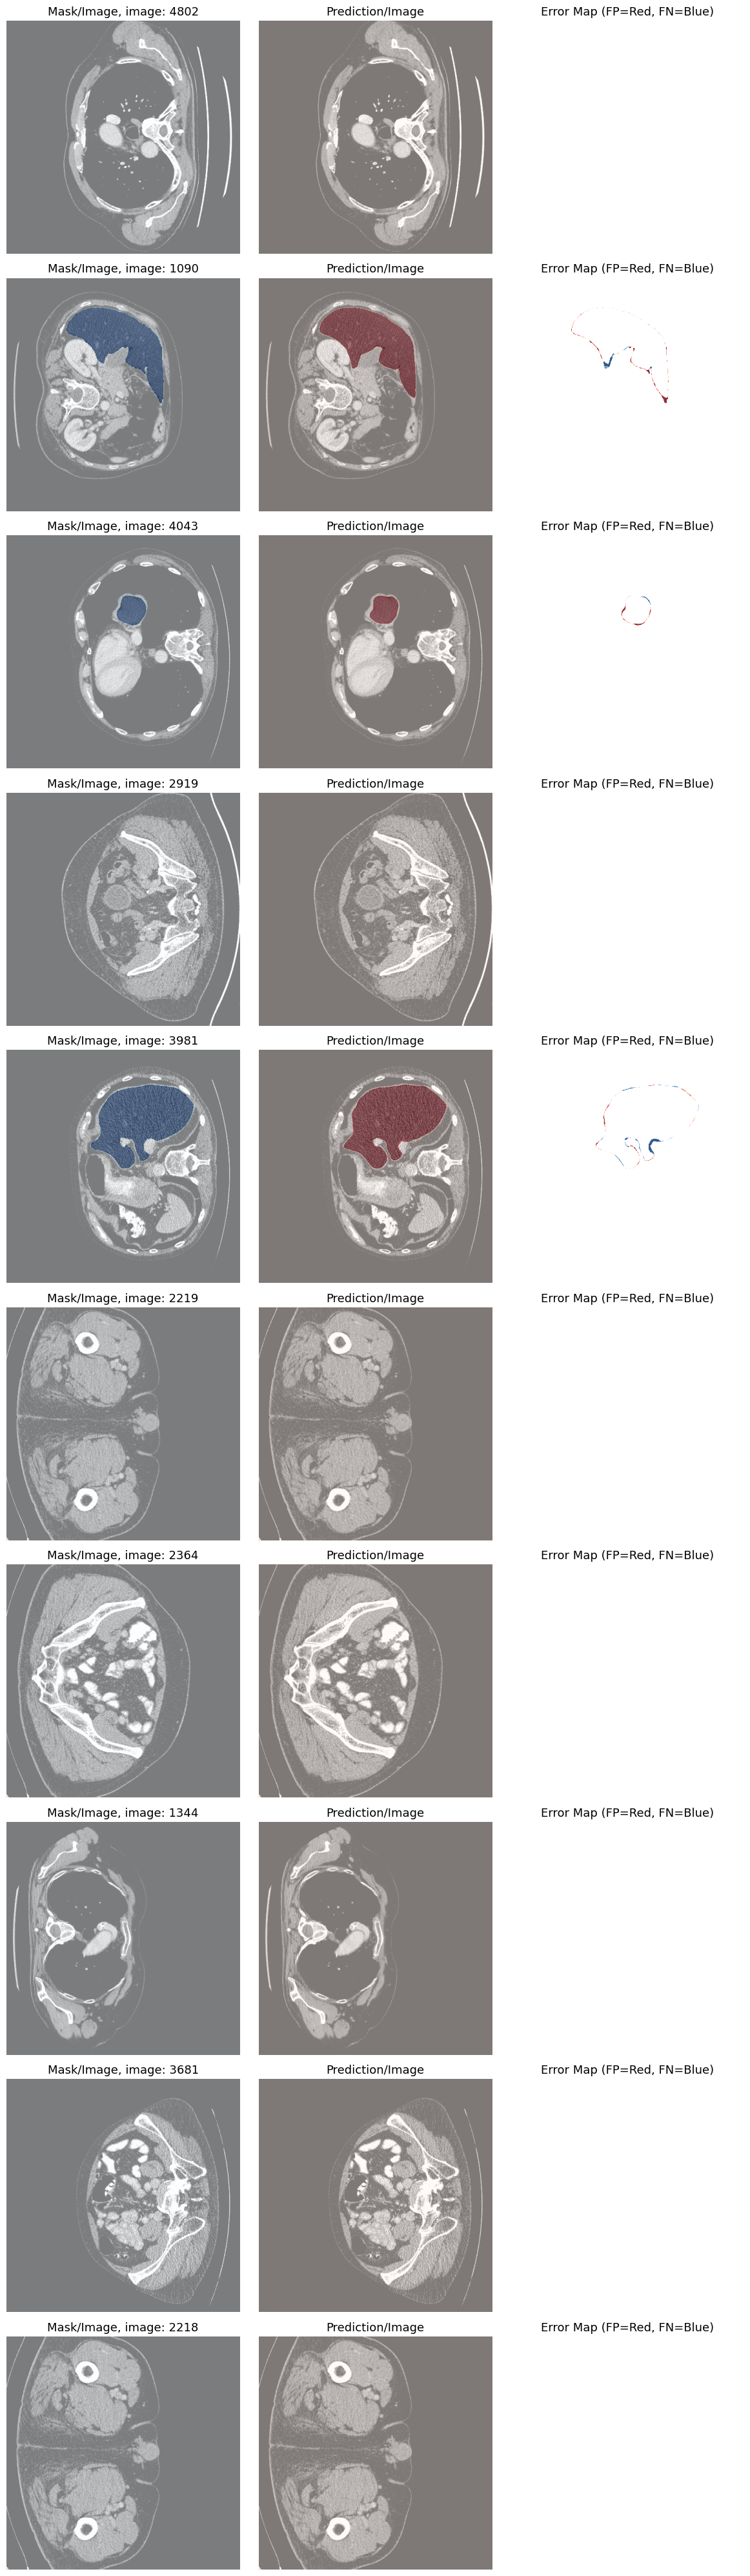

In [20]:
# random.seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

model = inference_model
model = model.to(device)
model.eval()

VAL_DIR = "/kaggle/input/preprocess-2d-data/preprocessed_data/val"
val_image_paths = sorted(glob.glob(f"{VAL_DIR}/images/*.npz"))
val_mask_paths = sorted(glob.glob(f"{VAL_DIR}/masks/*.npz"))
total_image = len(val_image_paths)

random_indices = random.sample(range(total_image), k=10)

fig = plt.figure(figsize=(12, 4 * len(random_indices)))

for index, random_index in enumerate(random_indices):
    image = np.load(val_image_paths[random_index])["data"].astype(np.float32)
    mask = np.load(val_mask_paths[random_index])["data"].astype(np.float32)

    original_image = image[:, :, 1]

    # Convert image to tensor
    image_tensor = ToTensorV2()(image=image)["image"] # (1, H, W)
    image_tensor = image_tensor.unsqueeze(0).to(device)
    
    with torch.inference_mode():
        logits = model(image_tensor)
        pred_image = (torch.sigmoid(logits).cpu().numpy() > 0.5).astype(np.uint8).squeeze()

    # Visualize
    ax1 = plt.subplot(len(random_indices), 3, index*3 + 1)
    ax1.imshow(original_image, cmap="gray")
    ax1.imshow(mask, cmap="Blues", alpha=0.5)
    ax1.set_title(f"Mask/Image, image: {random_index}", fontsize=13)
    ax1.axis("off")

    ax2 = plt.subplot(len(random_indices), 3, index*3 + 2)
    ax2.imshow(original_image, cmap="gray")
    ax2.imshow(pred_image, cmap="Reds", alpha=0.5)
    ax2.set_title("Prediction/Image", fontsize=13)
    ax2.axis("off")

    ax3 = plt.subplot(len(random_indices), 3, index*3 + 3)
    fp = np.logical_and(pred_image == 1, mask == 0)   # False Positive
    fn = np.logical_and(pred_image == 0, mask == 1)   # False Negative
    ax3.imshow(fp, cmap="Blues", alpha=fp * 0.8)
    ax3.imshow(fn, cmap="Reds", alpha=fn * 0.8)
    ax3.set_title("Error Map (FP=Red, FN=Blue)", fontsize=13)
    ax3.axis("off")
    
plt.tight_layout()

## Visualize k random slices by 4 bins (IQR)


=== Bin 1 (Low FG) — showing 5 random slices ===


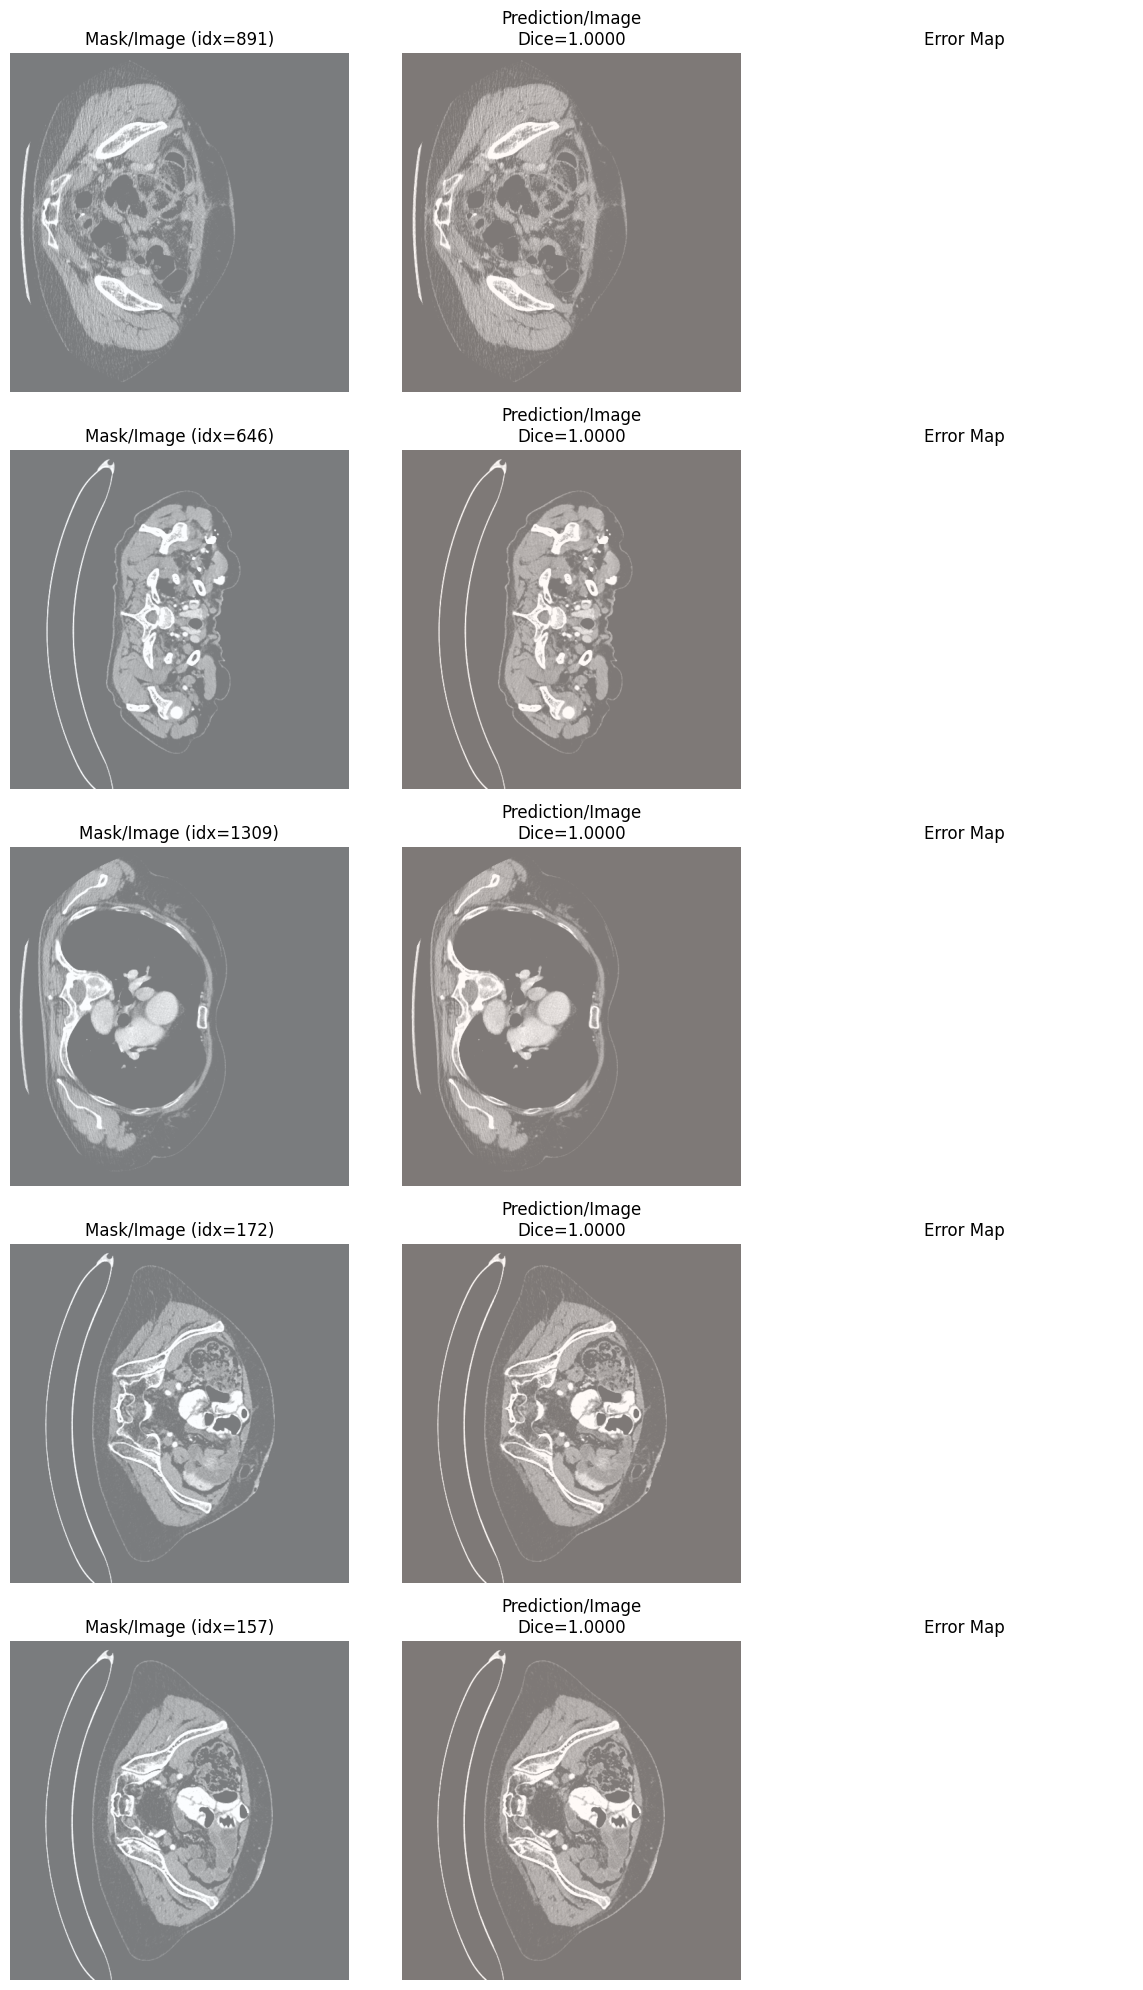


=== Bin 3 (Medium-High) — showing 5 random slices ===


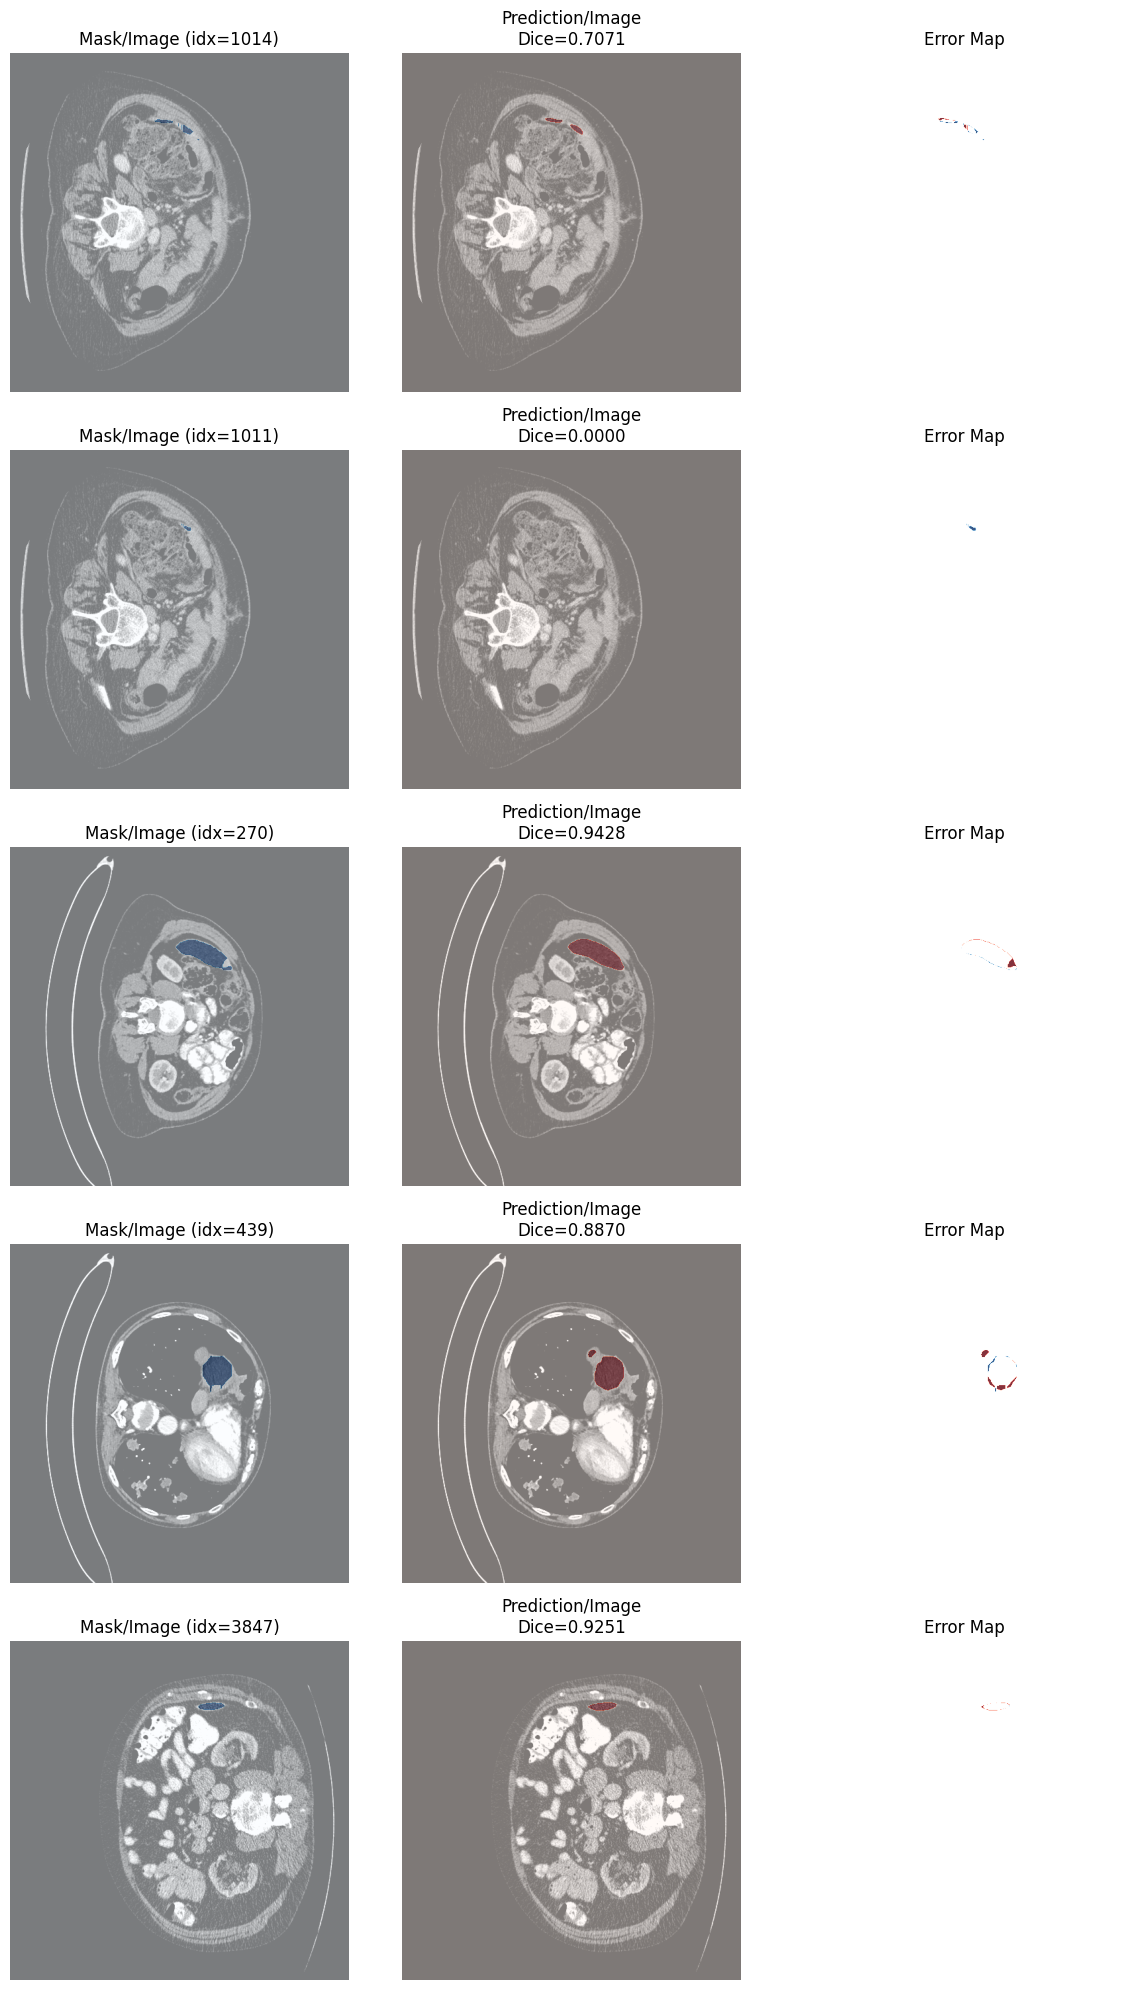


=== Bin 4 (High FG) — showing 5 random slices ===


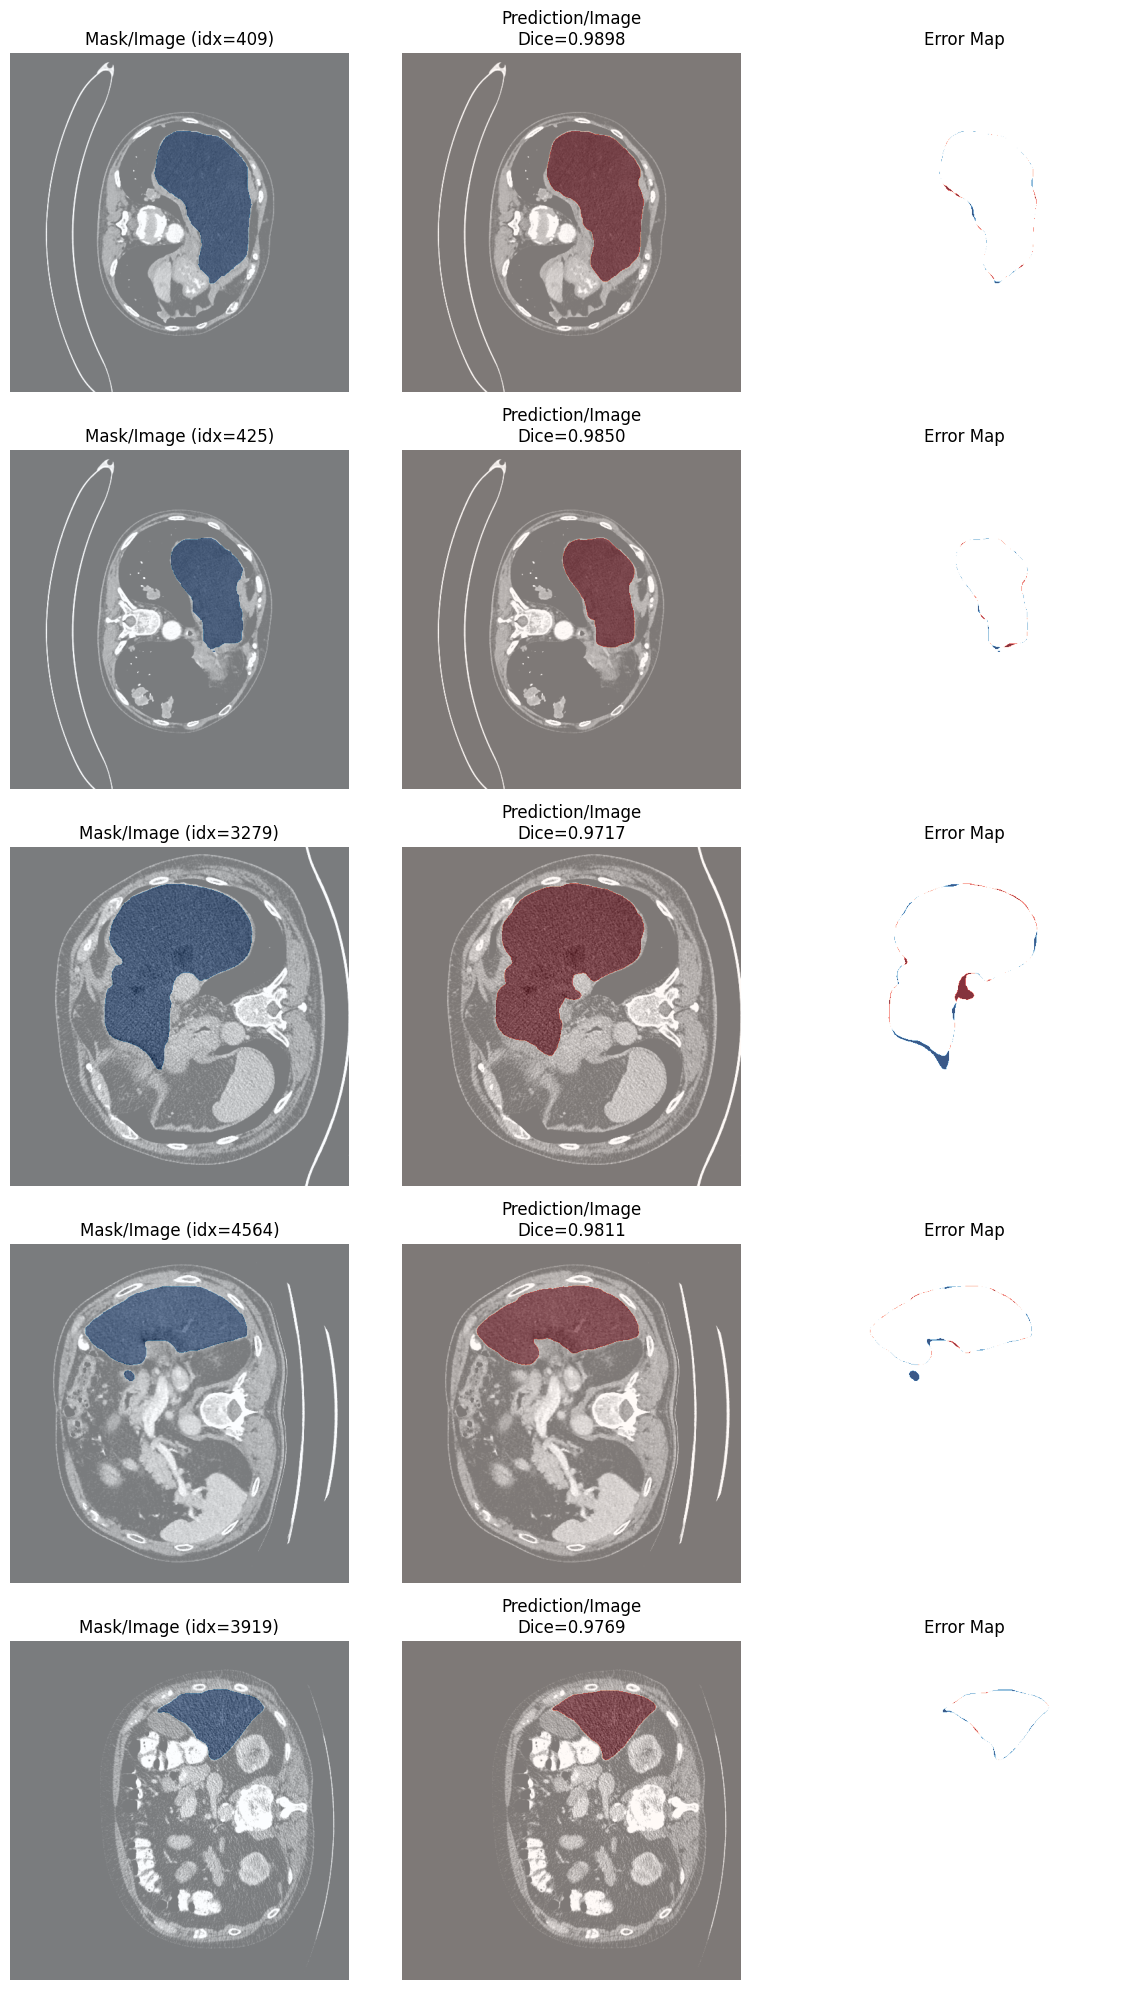

In [21]:
# ==================== CONFIG =====================
VAL_DIR = "/kaggle/input/preprocess-2d-data/preprocessed_data/val"
K = 5   # Total numbers for each bin
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = inference_model.to(DEVICE).eval()
# =================================================
def dice_score(mask, pred):
    mask = mask.astype(bool)
    pred = pred.astype(bool)

    if mask.sum() == 0 and pred.sum() == 0:
        return 1.0
    if mask.sum() == 0 and pred.sum() > 0:
        return 0.0

    inter = (mask & pred).sum()
    dice = 2 * inter / (mask.sum() + pred.sum())
    return float(dice)


# ===== Read val slices =====
val_images = sorted(glob.glob(f"{VAL_DIR}/images/*.npz"))
val_masks = sorted(glob.glob(f"{VAL_DIR}/masks/*.npz"))

N = len(val_images)
foreground_ratio = []

for i in range(N):
    m = np.load(val_masks[i])["data"].astype(np.float32)
    fg = (m > 0).mean()
    foreground_ratio.append(fg)

foreground_ratio = np.array(foreground_ratio)

# Tính 4 bin theo quartile
q1, q2, q3 = np.percentile(foreground_ratio, [25, 50, 75])

bins = [
    np.where(foreground_ratio <= q1)[0],                              # Bin 1
    np.where((foreground_ratio > q1) & (foreground_ratio <= q2))[0],  # Bin 2
    np.where((foreground_ratio > q2) & (foreground_ratio <= q3))[0],  # Bin 3
    np.where(foreground_ratio > q3)[0],                               # Bin 4
]

bin_names = ["Low FG", "Medium-Low", "Medium-High", "High FG"]

# ==================== Visualization =====================
for b_idx, indices in enumerate(bins):
    if len(indices) == 0:
        continue

    print(f"\n=== Bin {b_idx+1} ({bin_names[b_idx]}) — showing {K} random slices ===")

    chosen = random.sample(list(indices), min(K, len(indices)))

    fig = plt.figure(figsize=(12, 4 * len(chosen)))

    for j, idx in enumerate(chosen):

        img = np.load(val_images[idx])["data"].astype(np.float32)
        mask = np.load(val_masks[idx])["data"].astype(np.float32)
        original = img[:, :, 1]  # slice middle nếu là 3-channel

        # tensor
        tensor = ToTensorV2()(image=img)["image"].unsqueeze(0).to(DEVICE)

        with torch.inference_mode():
            logit = model(tensor)
            pred = (torch.sigmoid(logit).cpu().numpy() > 0.5).astype(np.uint8).squeeze()

        dice = dice_score(mask, pred)

        # ==== Plot layout: mask, pred, error ====
        ax1 = plt.subplot(len(chosen), 3, j*3 + 1)
        ax1.imshow(original, cmap="gray")
        ax1.imshow(mask, cmap="Blues", alpha=0.5)
        ax1.set_title(f"Mask/Image (idx={idx})")
        ax1.axis("off")

        ax2 = plt.subplot(len(chosen), 3, j*3 + 2)
        ax2.imshow(original, cmap="gray")
        ax2.imshow(pred, cmap="Reds", alpha=0.5)
        ax2.set_title(f"Prediction/Image\nDice={dice:.4f}")
        ax2.axis("off")

        # Error map
        fp = (pred == 1) & (mask == 0)
        fn = (pred == 0) & (mask == 1)

        ax3 = plt.subplot(len(chosen), 3, j*3 + 3)
        ax3.imshow(fp, cmap="Reds", alpha=fp*0.8)
        ax3.imshow(fn, cmap="Blues", alpha=fn*0.8)
        ax3.set_title("Error Map")
        ax3.axis("off")

    plt.tight_layout()
    plt.show()

## Visualize top K bad predictions

In [26]:
def dice_score(mask, pred):
    mask = mask.astype(bool)
    pred = pred.astype(bool)

    if mask.sum() == 0 and pred.sum() == 0:
        return 1.0
    if mask.sum() == 0 and pred.sum() > 0:
        return 0.0

    inter = (mask & pred).sum()
    return 2 * inter / (mask.sum() + pred.sum())


# ===== Read val slices =====
val_images = sorted(glob.glob(f"{VAL_DIR}/images/*.npz"))
val_masks = sorted(glob.glob(f"{VAL_DIR}/masks/*.npz"))

scores = []

# Compute Dice for entire valset
for idx in tqdm(range(len(val_images)), desc="Inference in Validation data"):
    img = np.load(val_images[idx])["data"].astype(np.float32)
    mask = np.load(val_masks[idx])["data"].astype(np.float32)

    tensor = ToTensorV2()(image=img)["image"].unsqueeze(0).to(device)

    with torch.inference_mode():
        logit = model(tensor)
        pred = (torch.sigmoid(logit).cpu().numpy() > 0.5).astype(np.uint8).squeeze()

    dice = dice_score(mask, pred)
    scores.append((dice, idx))

Inference in Validation data:   0%|          | 0/4936 [00:00<?, ?it/s]


=== Worst K slices by Dice ===
idx=255, Dice=0.0000
idx=446, Dice=0.0000
idx=1010, Dice=0.0000
idx=1011, Dice=0.0000
idx=1012, Dice=0.0000
idx=1013, Dice=0.0000
idx=1724, Dice=0.0000
idx=1725, Dice=0.0000
idx=2074, Dice=0.0000
idx=2119, Dice=0.0000


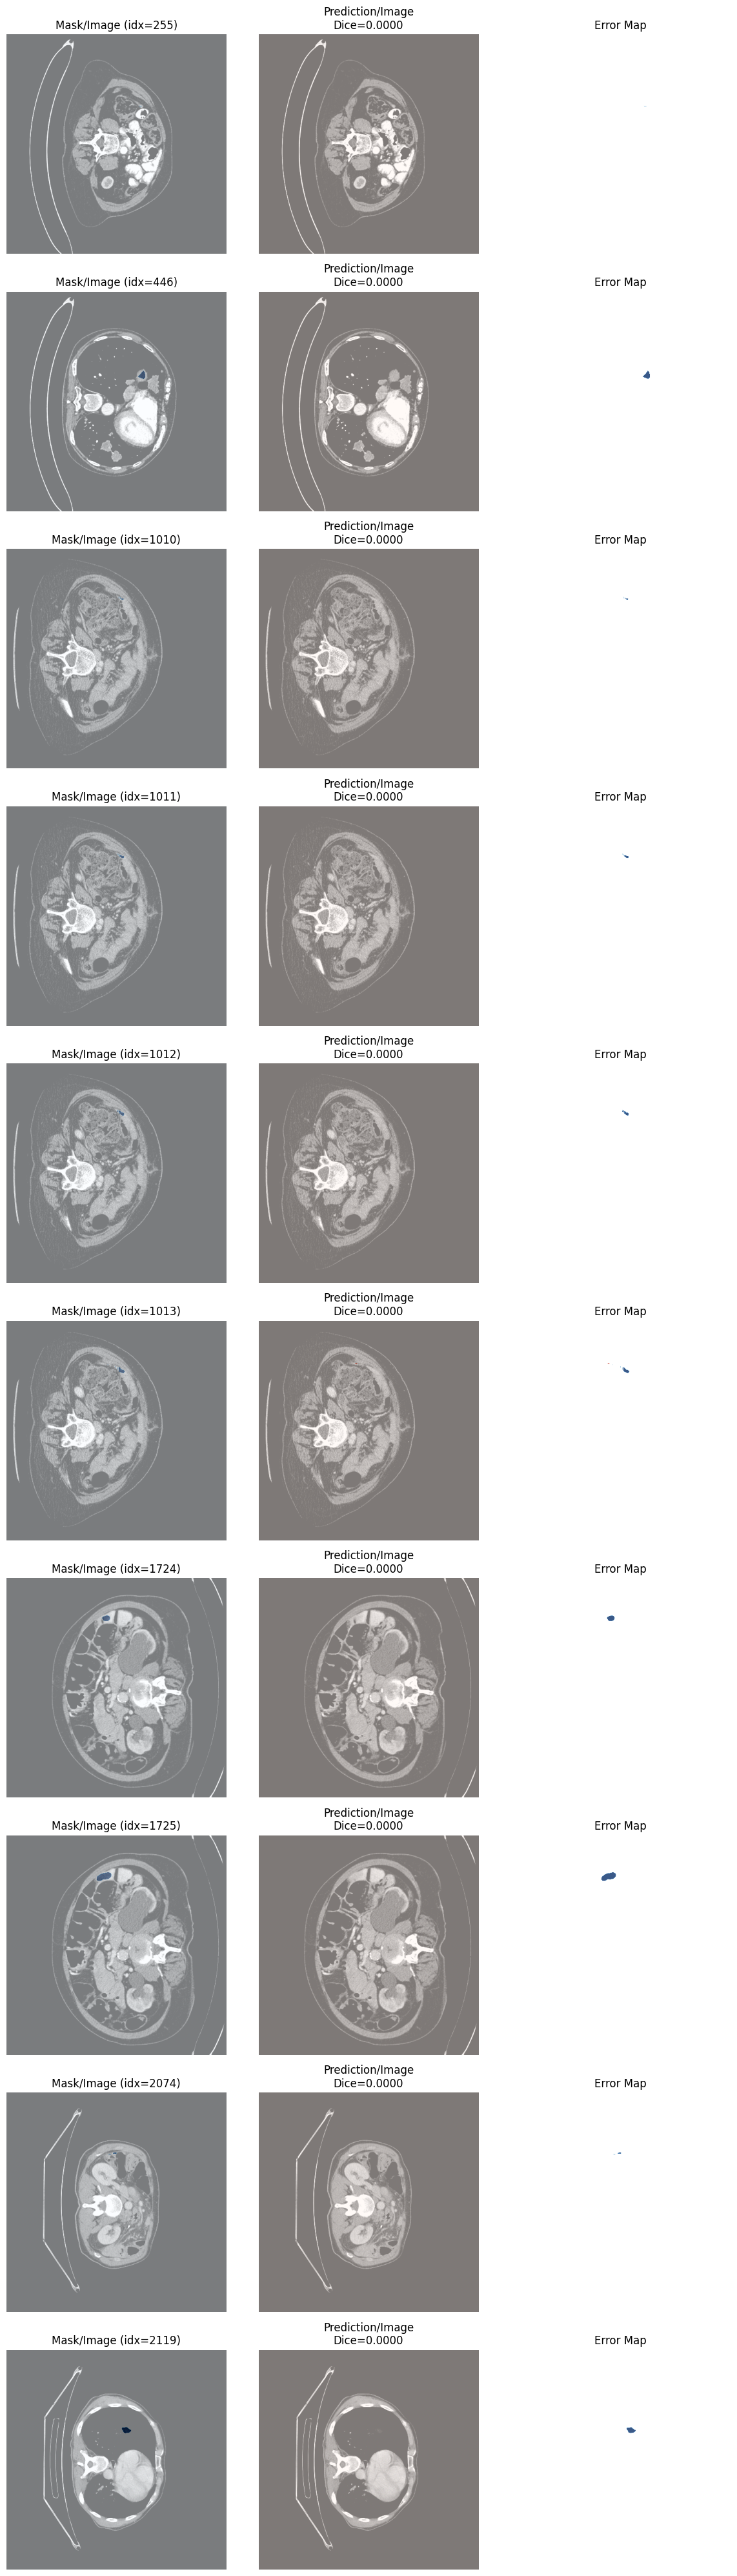

In [27]:
# ================== CONFIG ======================
K = 10  # The number of bad predictions that we want to visualize
# =================================================

# Sort by Dice ascending (worst first)
scores = sorted(scores, key=lambda x: x[0])

# Take top K worst
worst = scores[:K]

print("\n=== Worst K slices by Dice ===")
for d, idx in worst:
    print(f"idx={idx}, Dice={d:.4f}")
# ================= Visualization ==================
fig = plt.figure(figsize=(12, 4 * K))

for j, (d, idx) in enumerate(worst):
    img = np.load(val_images[idx])["data"].astype(np.float32)
    mask = np.load(val_masks[idx])["data"].astype(np.float32)
    original = img[:, :, 1]

    tensor = ToTensorV2()(image=img)["image"].unsqueeze(0).to(DEVICE)

    with torch.inference_mode():
        logit = model(tensor)
        pred = (torch.sigmoid(logit).cpu().numpy() > 0.5).astype(np.uint8).squeeze()

    # Plot
    ax1 = plt.subplot(K, 3, j*3 + 1)
    ax1.imshow(original, cmap="gray")
    ax1.imshow(mask, cmap="Blues", alpha=0.5)
    ax1.set_title(f"Mask/Image (idx={idx})")
    ax1.axis("off")

    ax2 = plt.subplot(K, 3, j*3 + 2)
    ax2.imshow(original, cmap="gray")
    ax2.imshow(pred, cmap="Reds", alpha=0.5)
    ax2.set_title(f"Prediction/Image\nDice={d:.4f}")
    ax2.axis("off")

    fp = (pred == 1) & (mask == 0)
    fn = (pred == 0) & (mask == 1)

    ax3 = plt.subplot(K, 3, j*3 + 3)
    ax3.imshow(fp, cmap="Reds", alpha=fp*0.8)
    ax3.imshow(fn, cmap="Blues", alpha=fn*0.8)
    ax3.set_title("Error Map")
    ax3.axis("off")

plt.tight_layout()
plt.show()